# Load modules and Set constants

In [1]:
import os, cv2, glob
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
WIDTH, HEIGHT =256, 256

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '37',
    'date' : '09-06-2021',
    'description' : 'Compute Mean Squared Error of same groups\n'
    }

ROOT_DIR = os.path.join('C:\\', 'GitHub', 'Lab_Experiment', 'Trajectory_Clustering')

GEOLIFE_DIR = os.path.join('C:\\', 'Dataset', 'Geolife')
LOW_DIMENSION_DIR = os.path.join(GEOLIFE_DIR, 'Low_Dimension')
IMAGE_DIR = os.path.join(GEOLIFE_DIR, 'Image_Files')

RESULT_DIR = os.path.join( 'C:\\', 'GitHub', 'Lab_Experiment', 'Results')

os.chdir(RESULT_DIR)
curr_result_name = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Results"
if (curr_result_name not in os.listdir()):
    os.mkdir(curr_result_name)

CURR_RESULT_DIR = os.path.join(RESULT_DIR, curr_result_name)
os.chdir(CURR_RESULT_DIR)

with open('Description.txt', 'w') as f:
    f.write(EXPERIMENT_DATA['description'])

print(f'ROOT_DIR:          {ROOT_DIR}')
print(f'GEOLIFE_DIR:       {GEOLIFE_DIR}')
print(f'LOW_DIMENSION_DIR: {LOW_DIMENSION_DIR}')
print(f'IMAGE_DIR:         {IMAGE_DIR}')
print(f'RESULT_DIR:        {RESULT_DIR}')
print(f'CURR_RESULT_DIR:   {CURR_RESULT_DIR}')

ROOT_DIR:          C:\GitHub\Lab_Experiment\Trajectory_Clustering
GEOLIFE_DIR:       C:\Dataset\Geolife
LOW_DIMENSION_DIR: C:\Dataset\Geolife\Low_Dimension
IMAGE_DIR:         C:\Dataset\Geolife\Image_Files
RESULT_DIR:        C:\GitHub\Lab_Experiment\Results
CURR_RESULT_DIR:   C:\GitHub\Lab_Experiment\Results\Trajectory_Clusetring_37_09-06-2021_Results


# Load Data

In [3]:
os.chdir(IMAGE_DIR)
file_names = sorted(glob.glob('*png'))

In [4]:
group1 = set([17333, 8009, 8561, 5894, 13593, 12020, 2311, 3792, 13869, 17068])
group2 = set([14586, 9973, 3725, 17410])
group3 = set([13948, 15894, 13593, 1433, 7550])

groups = [group1, group2, group3]

In [5]:
trajectory_images = [ ]
for idx, group in enumerate(groups):
    trajectory_images.append([])
    for file in group:
        trajectory_images[idx].append(cv2.imread(file_names[file], cv2.IMREAD_GRAYSCALE))

In [6]:
X_train1 = np.array(trajectory_images[0]).astype('float32') / 255.
X_train1 = np.reshape(X_train1, (-1, HEIGHT, WIDTH, 1))

X_train2 = np.array(trajectory_images[1]).astype('float32') / 255.
X_train2 = np.reshape(X_train2, (-1, HEIGHT, WIDTH, 1))

X_train3 = np.array(trajectory_images[2]).astype('float32') / 255.
X_train3 = np.reshape(X_train3, (-1, HEIGHT, WIDTH, 1))

# Load Models

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
os.chdir(os.path.join(ROOT_DIR, 'Models', 'Crop_Img'))
encoder = keras.models.load_model('encoder.h5')
# decoder =  keras.models.load_model('decoder.h5')
auto_encoder = keras.models.load_model('auto_encoder.h5')

# Get similar data

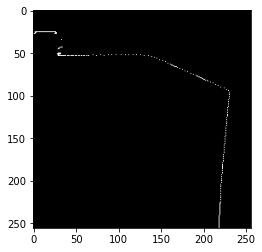

In [12]:
os.chdir(CURR_RESULT_DIR)

plt.gray()
plt.imshow(trajectory_images[0][0])
plt.savefig('First_Image.png', dpi = 100)
plt.show()

In [15]:
def load_low_dimension_data(dir_name: str) -> list:
    low_dimension = []

    os.chdir(os.path.join(LOW_DIMENSION_DIR, dir_name))
    for data in sorted(glob.glob('*data')):
        with open(data, 'rb') as f:
             low_dimension.append(pkl.load(f))
                
    return np.array(low_dimension)

In [41]:
from scipy.spatial import distance

def get_MSE(list1: np.array, list2: np.array) -> float:
    similarities = [ ]
    for low_dim1, low_dim2 in zip(list1, list2):
        similarities.append(distance.cosine(low_dim1, low_dim2))

    return np.square(sum(similarities)) / len(similarities)

In [17]:
map_table = pd.read_csv(GEOLIFE_DIR + '\Map_Table.csv', header = 0)
print(map_table.keys())
map_table.head()

Index(['ImageNumber', ' LowDimNumber'], dtype='object')


,ImageNumber,LowDimNumber
0,1,0
1,10,64
2,100,128
3,1000,192
4,10000,256


In [36]:
def match_image_to_lowDim(img_name: str) -> int:
    front = int(img_name.split('.')[0][len('Geolife_trajectory'):])
    
    return str(map_table[map_table['ImageNumber'] == front].iloc[0][' LowDimNumber'])

In [48]:
similar_images = []
for idx, i in enumerate(group1):
    img_name = file_names[i]
    base_low_dimension = load_low_dimension_data(match_image_to_lowDim(img_name) + 'th data')

    similar_images.append([])    
    for j in group1:
        img_name = file_names[j]
        lowDim_name = match_image_to_lowDim(img_name)

        curr_low_dimension = load_low_dimension_data(lowDim_name + 'th data')

        similar_images[idx].append(get_MSE(base_low_dimension, curr_low_dimension))

print(similar_images)

os.chdir(CURR_RESULT_DIR)
with open('MSE_of_Group1.txt', 'wt') as f:
    for i in range(len(similar_images)):
        for j in range(len(similar_images[i])):
            f.write(f'{similar_images[i][j]:.3f}, ')
        f.write('\n')

[[0.0, 0.4732642954583801, 0.4556793123277034, 0.9341172797131492, 0.6429010624594975, 0.3970917991255268, 0.6531133482896259, 0.5960843277745402, 0.2058625310728479, 0.408583614698955], [0.4732642954583801, 0.0, 0.623144331991913, 0.926282476633205, 0.730005028057267, 0.5219808156399728, 0.6764575903091163, 0.6815078506643362, 0.467019416155795, 0.6229943875527519], [0.4556793123277034, 0.623144331991913, 0.0, 1.126012867502466, 0.8946819473459853, 0.6466567674999704, 0.744801840646248, 0.6232404503611826, 0.6968416146253651, 0.5794756265375778], [0.9341172797131492, 0.926282476633205, 1.126012867502466, 0.0, 1.0490277626375026, 0.6003132313605675, 0.8876758601366732, 0.9736439923381477, 0.919969868594672, 1.1337508250193198], [0.6429010624594975, 0.730005028057267, 0.8946819473459853, 1.0490277626375026, 0.0, 0.6638148443410208, 0.7309179144739666, 0.7983619688595422, 0.717053898502003, 0.8374637020265601], [0.3970917991255268, 0.5219808156399728, 0.6466567674999704, 0.60031323136056

In [49]:
similar_images = []
for idx, i in enumerate(group2):
    img_name = file_names[i]
    base_low_dimension = load_low_dimension_data(match_image_to_lowDim(img_name) + 'th data')

    similar_images.append([])    
    for j in group2:
        img_name = file_names[j]
        lowDim_name = match_image_to_lowDim(img_name)

        curr_low_dimension = load_low_dimension_data(lowDim_name + 'th data')

        similar_images[idx].append(get_MSE(base_low_dimension, curr_low_dimension))

print(similar_images)

os.chdir(CURR_RESULT_DIR)
with open('MSE_of_Group2.txt', 'wt') as f:
    for i in range(len(similar_images)):
        for j in range(len(similar_images[i])):
            f.write(f'{similar_images[i][j]:.3f}, ')
        f.write('\n')

[[0.0, 1.1284260701742719, 0.8667217986172782, 1.1196876683452053], [1.1284260701742719, 0.0, 0.6488950683518846, 0.811015182628696], [0.8667217986172782, 0.6488950683518846, 0.0, 0.5550805042165345], [1.1196876683452053, 0.811015182628696, 0.5550805042165345, 0.0]]


In [50]:
similar_images = []
for idx, i in enumerate(group3):
    img_name = file_names[i]
    base_low_dimension = load_low_dimension_data(match_image_to_lowDim(img_name) + 'th data')

    similar_images.append([])    
    for j in group3:
        img_name = file_names[j]
        lowDim_name = match_image_to_lowDim(img_name)

        curr_low_dimension = load_low_dimension_data(lowDim_name + 'th data')

        similar_images[idx].append(get_MSE(base_low_dimension, curr_low_dimension))

print(similar_images)

os.chdir(CURR_RESULT_DIR)
with open('MSE_of_Group3.txt', 'wt') as f:
    for i in range(len(similar_images)):
        for j in range(len(similar_images[i])):
            f.write(f'{similar_images[i][j]:.3f}, ')
        f.write('\n')

[[0.0, 0.5019183102805025, 0.4603675433551837, 0.5431205199596723, 0.21518864516295638], [0.5019183102805025, 0.0, 0.6577134783193341, 0.5971416031733432, 0.4186815036906266], [0.4603675433551837, 0.6577134783193341, 0.0, 0.7549168819946885, 0.4418836209269097], [0.5431205199596723, 0.5971416031733432, 0.7549168819946885, 0.0, 0.31021524091805747], [0.21518864516295638, 0.4186815036906266, 0.4418836209269097, 0.31021524091805747, 0.0]]
